#Problem 2

In [2]:
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt

##(2) Player class for random and safe players

In [3]:
class Player:
  def __init__(self, player_name, right_uniform_bound = 1, epsilon = 0.3, gamma = 0.9, learning_rate = 0.2):
    self.name = player_name
    self.right_uniform_bound = right_uniform_bound
    self.learning_rate = learning_rate
    self.epsilon = epsilon
    self.gamma = gamma
    #self.state_value = {}
    self.state_action_value = defaultdict(lambda: defaultdict(lambda: 0.0))
  
  def getAction(self, available_positions, current_board_position, player_symbol):
    #depending on the value of epsilon, we can switch between random and safe choosing action
    #when epsilon is 0 then the acton choosen is always safe that's best possible action
    #when epsilon is 1 then the acton choosen is random
    #in between values can act for epsilon greedy policies for choosing action
    if np.random.uniform(0, self.right_uniform_bound) < self.epsilon:
      index = np.random.choice(len(available_positions))
      action_taken = available_positions[index]
    else:
      value_maximum = -1000000000
      for p in available_positions:
        next_board_position = current_board_position.copy()
        next_board_position[p[0]][p[1]] = player_symbol
        """
        if self.state_value.get(str(next_board_position)) is None:
          value = 0
        else:
          value = self.state_value.get(str(next_board_position))
        """
        if len(self.state_action_value[str(next_board_position)].keys()) == 0:
          value = 0.0
        else:
          value = self.state_action_value[str(next_board_position)][str(max(self.state_action_value[str(next_board_position)], key=lambda possible_action: self.state_action_value[str(next_board_position)][possible_action]))]        
        if value >= value_maximum:
          value_maximum = value
          action_taken = p
    return action_taken

  """
  def recursiveReward(self, reward):
    for st in reversed(self.states_taken):
      if self.state_value.get(st) is None:
        self.state_value[st] = 0
      self.state_value[st] += self.learning_rate * (self.gamma * reward - self.state_value[st])
      reward = self.state_value[st]
  """
  def recursiveReward(self, reward, older_board_state, action, new_board_state):
    if len(self.state_action_value[str(new_board_state)].keys()) == 0:
      next_max_value = 0.0
    else:
      #print(self.state_action_value[str(new_board_state)], key=lambda possible_action: self.state_action_value[str(new_board_state)][possible_action])
      next_max_value = self.state_action_value[str(new_board_state)][str(max(self.state_action_value[str(new_board_state)], key=lambda possible_action: self.state_action_value[str(new_board_state)][possible_action]))]
    self.state_action_value[str(older_board_state)][str(action)] += self.learning_rate*(reward + self.gamma*next_max_value - self.state_action_value[str(older_board_state)][str(action)])


##(1) tictactoe environment

In [10]:
#let p1 be always agent such that it takes x and p2 be always opponent it takes o
class Tictactoe:
  def __init__(self, p1, p2):
    self.board = np.zeros((3, 3))
    self.p1 = p1
    self.p2 = p2
    #cointoss = 0
    cointoss = np.random.randint(2, size = 1)[0]
    if cointoss == 0:
      self.starting_player = 1
      self.player_symbol = 1
    else:
      self.player_symbol = -1
      self.starting_player = -1
    self.game_end_flag = False
  
  def availablePositions(self):
    available_positions = []
    for i in range(0, 3):
      for j in range(0, 3):
        if self.board[i][j] == 0:
          available_positions.append(tuple([i, j]))
    return available_positions
  
  def checkWinner(self):
    for i in range(0, 3):
      if sum(self.board[i, :]) == 3:
        self.game_end_flag = True
        return 1
      if sum(self.board[i, :]) == -3:
        self.game_end_flag = True
        return -1
    for i in range(0, 3):
      if sum(self.board[:, i]) == 3:
        self.game_end_flag = True
        return 1
      if sum(self.board[:, i]) == -3:
        self.game_end_flag = True
        return -1
    diagonal_sum = 0
    for i in range(0, 3):
      diagonal_sum += self.board[i, i]
    if diagonal_sum == 3:
      self.game_end_flag = True
      return 1
    if diagonal_sum == -3:
      self.game_end_flag = True
      return -1
    diagonal_sum = 0
    for i in range(0, 3):
      diagonal_sum += self.board[i, 3 - i - 1]
    if diagonal_sum == 3:
      self.game_end_flag = True
      return 1
    if diagonal_sum == -3:
      self.game_end_flag = True
      return -1
    
    if len(self.availablePositions()) == 0:
      self.game_end_flag = True
      return 0
    self.game_end_flag = False
    return None
  
  """
  def giveRewardToWinner(self, winner, board_state, action, next_state, player_symbol):
    if winner == 1:
      self.p1.recursiveReward(1)
      self.p2.recursiveReward(0)
    elif winner == -1:
      self.p1.recursiveReward(0)
      self.p2.recursiveReward(1)
    else:
      self.p1.recursiveReward(0.5)
      self.p2.recursiveReward(0.5)
  """

  def giveRewardToWinner(self, winner, board_state, action, next_state, player_symbol):
    #player 1 wins
    if winner == 1:
      self.p1.recursiveReward(1, board_state, action, next_state)
      self.p2.recursiveReward(-1, board_state, action, next_state)
    #player 2 wins
    elif winner == -1:
      self.p1.recursiveReward(-1, board_state, action, next_state)
      self.p2.recursiveReward(1, board_state, action, next_state)
    #draw happens
    elif winner == 0:
      if player_symbol == -1:
        self.p1.recursiveReward(-1, board_state, action, next_state)
      else:
        self.p2.recursiveReward(1, board_state, action, next_state)
    #game is still going on*/
    elif winner is None:
      if player_symbol == -1:
        self.p2.recursiveReward(0, board_state, action, next_state)
      else: 
        self.p1.recursiveReward(0, board_state, action, next_state)

  def resetSettings(self):
    self.board = np.zeros((3,3))
    cointoss = np.random.randint(2, size = 1)[0]
    if cointoss == 0:
      self.starting_player = 1
      self.player_symbol = 1
    else:
      self.player_symbol = -1
      self.starting_player = -1
    self.game_end_flag = False
    
  def play(self, right_uniform_bound = 1, epsilon = 1.0, learning_rate = 0.2, gamma = 0.9):
    #print("Entered play function")
    p3 = Player('p3', right_uniform_bound, epsilon)
    cointoss = np.random.randint(2, size = 1)[0]
    #cointoss = 0
    if cointoss == 0:
      player_symbol = 1
      #print("Entered cointoss == 0")
      while self.game_end_flag == False:
        #print("Entered while condition")
        available_positions = self.availablePositions()
        #print(available_positions)
        #let p1 to take an action based on the best choice
        p1_choosen_action = self.p1.getAction(available_positions, self.board, self.player_symbol)
        self.board[p1_choosen_action[0]][p1_choosen_action[1]] = self.player_symbol
        #self.printCurrentBoard()
        if self.player_symbol == -1:
          self.player_symbol = 1
        else:
          self.player_symbol = -1
        #self.p1.addState(str(self.board))
        winner = self.checkWinner()
        if winner is not None:
          return winner
        else:
          available_positions = self.availablePositions()
          #let p1 to take an action based on the best choice
          p3_choosen_action = p3.getAction(available_positions, self.board, self.player_symbol)
          self.board[p3_choosen_action[0]][p3_choosen_action[1]] = self.player_symbol
          #self.printCurrentBoard()
          if self.player_symbol == -1:
            self.player_symbol = 1
          else:
            self.player_symbol = -1
          #p3.addState(str(self.board))
          winner = self.checkWinner()
          if winner is not None:
            return winner
    else:
      player_symbol = -1
      while self.game_end_flag == False:
        available_positions = self.availablePositions()
        #let p1 to take an action based on the best choice
        p3_choosen_action = p3.getAction(available_positions, self.board, self.player_symbol)
        self.board[p3_choosen_action[0]][p3_choosen_action[1]] = self.player_symbol
        if self.player_symbol == -1:
          self.player_symbol = 1
        else:
          self.player_symbol = -1
        #p3.addState(str(self.board))
        winner = self.checkWinner()
        if winner is not None:
          return winner
        else:
          available_positions = self.availablePositions()
          #let p1 to take an action based on the best choice
          p1_choosen_action = self.p1.getAction(available_positions, self.board, self.player_symbol)
          self.board[p1_choosen_action[0]][p1_choosen_action[1]] = self.player_symbol
          if self.player_symbol == -1:
            self.player_symbol = 1
          else:
            self.player_symbol = -1
          #self.p1.addState(str(self.board))
          winner = self.checkWinner()
          if winner is not None:
            return winner
    #print("Exiting play function")
  
  def learn(self, iterations=10000, right_uniform_bound = 1, epsilon = 1.0, learning_rate = 0.2, gamma = 0.9):
    wins_counter_array = []
    for i in range(iterations):
      if self.starting_player == 1:
        while self.game_end_flag == False:
          available_positions = self.availablePositions()
          #print(available_positions)
          #let p1 to take an action based on the best choice
          p1_choosen_action = self.p1.getAction(available_positions, self.board, self.player_symbol)
          #print(p1_choosen_action)
          older_board = self.board
          self.board[p1_choosen_action[0]][p1_choosen_action[1]] = self.player_symbol
          if self.player_symbol == -1:
            self.player_symbol = 1
          else:
            self.player_symbol = -1
          #self.p1.addState(str(self.board))
          winner = self.checkWinner()
          if winner is not None:
            self.giveRewardToWinner(winner, older_board, p1_choosen_action, self.board, self.player_symbol)
            #reset setting of the board for further iterations 
            self.resetSettings()
            break
          else:
            self.giveRewardToWinner(winner, older_board, p1_choosen_action, self.board, self.player_symbol)
            available_positions = self.availablePositions()
            #let p2 take action based on best choice
            p2_choosen_action = self.p2.getAction(available_positions, self.board, self.player_symbol)
            #print(p2_choosen_action)
            older_board = self.board
            self.board[p2_choosen_action[0], p2_choosen_action[1]] = self.player_symbol
            if self.player_symbol == 1:
              self.player_symbol = -1
            else:
              self.player_symbol == 1
            #self.p2.addState(str(self.board))
            winner = self.checkWinner()
            if winner is not None:
              self.giveRewardToWinner(winner, older_board, p2_choosen_action, self.board, self.player_symbol)
              #reset setting of the board for further iterations 
              self.resetSettings()
              break
            self.giveRewardToWinner(winner, older_board, p2_choosen_action, self.board, self.player_symbol)
      else:
        while self.game_end_flag == False:
          available_positions = self.availablePositions()
          #let p1 to take an action based on the best choice
          p2_choosen_action = self.p2.getAction(available_positions, self.board, self.player_symbol)
          older_board = self.board
          self.board[p2_choosen_action[0]][p2_choosen_action[1]] = self.player_symbol
          if self.player_symbol == -1:
            self.player_symbol = 1
          else:
            self.player_symbol = -1
          #self.p2.addState(str(self.board))
          winner = self.checkWinner()
          if winner is not None:
            self.giveRewardToWinner(winner, older_board, p2_choosen_action, self.board, self.player_symbol)
            #reset setting of the board for further iterations 
            self.resetSettings()
            break
          else:
            self.giveRewardToWinner(winner, older_board, p2_choosen_action, self.board, self.player_symbol)
            available_positions = self.availablePositions()
            #let p2 take action based on best choice
            p1_choosen_action = self.p1.getAction(available_positions, self.board, self.player_symbol)
            older_board = self.board
            self.board[p1_choosen_action[0], p1_choosen_action[1]] = self.player_symbol
            if self.player_symbol == 1:
              self.player_symbol = -1
            else:
              self.player_symbol == 1
            #self.p1.addState(str(self.board))
            winner = self.checkWinner()
            if winner is not None:
              self.giveRewardToWinner(winner, older_board, p1_choosen_action, self.board, self.player_symbol)
              #reset setting of the board for further iterations 
              self.resetSettings()
              break
            self.giveRewardToWinner(winner, older_board, p1_choosen_action, self.board, self.player_symbol)
    
      if (i+1)%200 == 0:
        counter = 0
        for j in range(100):
          p = self.play(right_uniform_bound, epsilon)
          #print("temp: ", p)
          if p == 1:
            counter += 1
          self.resetSettings()
        wins_counter_array.append(counter)
        print("iteration {}: {}".format(i, counter))
    print("wins_counter_array: ", wins_counter_array)
    plt.plot(list(range(len(wins_counter_array))), wins_counter_array, '-go')
    plt.title("training time wins for 100 games after each 200 iterations")
    plt.show()
  
  def printCurrentBoard(self):
    print('-----------------')
    for i in range(0, 3):
      print('-   -   -')
      out = ''
      for j in range(0, 3):
        if j != 2:
          if self.board[i][j] == 1:
            out += 'x | '
          elif self.board[i][j] == -1:
            out += 'o | '
          elif self.board[i][j] == 0:
            out += '  | '
        else:
          if self.board[i][j] == 1:
            out += 'x '
          elif self.board[i][j] == -1:
            out += 'o '
          elif self.board[i][j] == 0:
            out += '  '
      print(out)
    print('-----------------')


##(c)(1)

iteration 199: 38
iteration 399: 45
iteration 599: 46
iteration 799: 41
iteration 999: 44
iteration 1199: 40
iteration 1399: 52
iteration 1599: 47
iteration 1799: 49
iteration 1999: 45
iteration 2199: 46
iteration 2399: 49
iteration 2599: 52
iteration 2799: 49
iteration 2999: 48
iteration 3199: 48
iteration 3399: 40
iteration 3599: 50
iteration 3799: 40
iteration 3999: 44
iteration 4199: 49
iteration 4399: 59
iteration 4599: 51
iteration 4799: 46
iteration 4999: 55
iteration 5199: 51
iteration 5399: 54
iteration 5599: 46
iteration 5799: 42
iteration 5999: 43
iteration 6199: 48
iteration 6399: 46
iteration 6599: 46
iteration 6799: 49
iteration 6999: 44
iteration 7199: 44
iteration 7399: 52
iteration 7599: 55
iteration 7799: 54
iteration 7999: 49
iteration 8199: 50
iteration 8399: 43
iteration 8599: 52
iteration 8799: 52
iteration 8999: 55
iteration 9199: 61
iteration 9399: 53
iteration 9599: 52
iteration 9799: 47
iteration 9999: 49
wins_counter_array:  [38, 45, 46, 41, 44, 40, 52, 47, 4

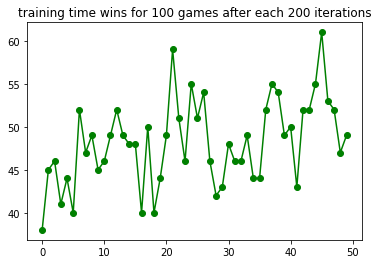

score:  {'win': 495, 'loss': 440, 'draw': 65}


In [6]:
#player1 is agent who always chooses the best move possible checking the Q learning table
p1 = Player("p1", right_uniform_bound = 1, epsilon = 0.0)
#player2 is safe player who always chooses the best move possible based on its own Q learning table
p2 = Player("p2", right_uniform_bound = 1, epsilon = 1.0)
temp = Tictactoe(p1, p2)
temp.learn(10000, right_uniform_bound = 1, epsilon = 0.5)

#1000 game with both safe and random opponent, the choice of opponent is random and based on the uniformly choosen value between (0, 1) 
score = {'win': 0, 'loss': 0, 'draw': 0}
for i in range(1000):
  p = temp.play(right_uniform_bound = 1, epsilon = 0.5)
  #print("temp: ", p)
  if p == 1:
    score['win'] += 1
  elif p == -1:
    score['loss'] += 1
  elif p == 0:
    score['draw'] += 1
  temp.resetSettings()
# score for 1000 games against random and safe opponent 
print("score: ", score)

##(c)(2)

iteration 199: 47
iteration 399: 52
iteration 599: 38
iteration 799: 41
iteration 999: 41
iteration 1199: 48
iteration 1399: 43
iteration 1599: 45
iteration 1799: 47
iteration 1999: 44
iteration 2199: 47
iteration 2399: 46
iteration 2599: 45
iteration 2799: 44
iteration 2999: 46
iteration 3199: 49
iteration 3399: 36
iteration 3599: 46
iteration 3799: 42
iteration 3999: 52
iteration 4199: 51
iteration 4399: 44
iteration 4599: 47
iteration 4799: 49
iteration 4999: 53
iteration 5199: 50
iteration 5399: 52
iteration 5599: 40
iteration 5799: 42
iteration 5999: 43
iteration 6199: 62
iteration 6399: 45
iteration 6599: 41
iteration 6799: 55
iteration 6999: 54
iteration 7199: 43
iteration 7399: 45
iteration 7599: 47
iteration 7799: 44
iteration 7999: 51
iteration 8199: 55
iteration 8399: 41
iteration 8599: 43
iteration 8799: 51
iteration 8999: 55
iteration 9199: 40
iteration 9399: 44
iteration 9599: 35
iteration 9799: 40
iteration 9999: 41
wins_counter_array:  [47, 52, 38, 41, 41, 48, 43, 45, 4

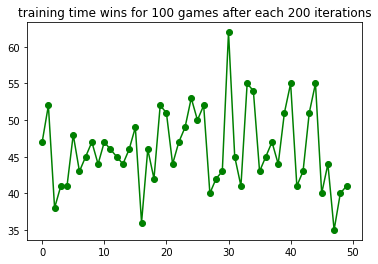

score:  {'win': 473, 'loss': 445, 'draw': 82}


In [7]:
#player1 is agent who always chooses the best move possible checking the Q learning table
p1 = Player("p1", right_uniform_bound = 1, epsilon = 0.0)
#player2 is safe player who always chooses the best move possible based on its own Q learning table
p2 = Player("p2", right_uniform_bound = 1, epsilon = 0.0)
temp = Tictactoe(p1, p2)
temp.learn(10000, right_uniform_bound = 1, epsilon = 0.5)

#1000 game with both safe and random opponent, the choice of opponent is random and based on the uniformly choosen value between (0, 1) 
score = {'win': 0, 'loss': 0, 'draw': 0}
for i in range(1000):
  p = temp.play(right_uniform_bound = 1, epsilon = 0.5)
  #print("temp: ", p)
  if p == 1:
    score['win'] += 1
  elif p == -1:
    score['loss'] += 1
  elif p == 0:
    score['draw'] += 1
  temp.resetSettings()
# score for 1000 games against random and safe opponent
print("score: ", score)

##(c)(3)

iteration 199: 53
iteration 399: 50
iteration 599: 50
iteration 799: 44
iteration 999: 47
iteration 1199: 47
iteration 1399: 47
iteration 1599: 36
iteration 1799: 48
iteration 1999: 49
iteration 2199: 54
iteration 2399: 38
iteration 2599: 44
iteration 2799: 45
iteration 2999: 50
iteration 3199: 49
iteration 3399: 50
iteration 3599: 40
iteration 3799: 52
iteration 3999: 52
iteration 4199: 44
iteration 4399: 41
iteration 4599: 50
iteration 4799: 51
iteration 4999: 51
iteration 5199: 47
iteration 5399: 45
iteration 5599: 52
iteration 5799: 51
iteration 5999: 48
iteration 6199: 59
iteration 6399: 45
iteration 6599: 50
iteration 6799: 40
iteration 6999: 42
iteration 7199: 44
iteration 7399: 45
iteration 7599: 51
iteration 7799: 49
iteration 7999: 35
iteration 8199: 48
iteration 8399: 52
iteration 8599: 55
iteration 8799: 53
iteration 8999: 51
iteration 9199: 62
iteration 9399: 56
iteration 9599: 49
iteration 9799: 49
iteration 9999: 48
wins_counter_array:  [53, 50, 50, 44, 47, 47, 47, 36, 4

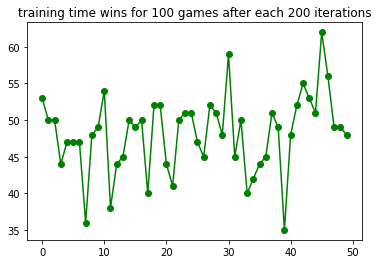

score:  {'win': 459, 'loss': 454, 'draw': 87}


In [11]:
#player1 is agent who always chooses the best move possible checking the Q learning table
p1 = Player("p1", right_uniform_bound = 1, epsilon = 0.0)
#player2 is safe player who always chooses the best move possible based on its own Q learning table
p2 = Player("p2", right_uniform_bound = 1, epsilon = 0.5)
temp = Tictactoe(p1, p2)
temp.learn(10000, right_uniform_bound = 1, epsilon = 0.5)

#1000 game with both safe and random opponent, the choice of opponent is random and based on the uniformly choosen value between (0, 1) 
score = {'win': 0, 'loss': 0, 'draw': 0}
for i in range(1000):
  p = temp.play(right_uniform_bound = 1, epsilon = 0.5)
  #print("temp: ", p)
  if p == 1:
    score['win'] += 1
  elif p == -1:
    score['loss'] += 1
  elif p == 0:
    score['draw'] += 1
  temp.resetSettings()
# score for 1000 games against random and safe opponent
print("score: ", score)

##(c)(4) 

Among above three trained agent, with respect to the training graph agent who trained against random opponent seems trained in a good manner as the graph looks little promising with increasing number of wins from the first iteration.

##(c)(5)

The Q-learning agent doesnot seem unbeatable based on the scores for win, loss and draw for all the three scenarios. The training process can be improved by changing the reward function for the win, loss and draw for Q-learning agent. 